In [1]:
#!/usr/bin/env python3
import subprocess
import re
import csv

# Regex patterns (max 4 words per comment)
pat_cpu_vam = re.compile(r"CPU VAM solver completed in ([0-9.]+) seconds")
pat_gpu_vam = re.compile(r"GPU VAM solver completed in ([0-9.]+) seconds")
pat_cpu_lcm = re.compile(r"CPU LCM solver completed in ([0-9.]+) seconds")
pat_gpu_lcm = re.compile(r"GPU LCM solver completed in ([0-9.]+) seconds")
pat_cpu_modi = re.compile(r"CPU MODI solver completed in ([0-9.]+) seconds")
pat_gpu_modi = re.compile(r"Phase 2 optimization \(GPU MODI\) in:\s*([0-9.]+) seconds")
pat_cpu_ssm  = re.compile(r"Accelerated CPU SSM solver completed in ([0-9.]+) seconds")
pat_gpu_ssm  = re.compile(r"Phase 2 optimization \(GPU SSM\) in:\s*([0-9.]+) seconds")

# Run TPSolver and capture output
def run_tpsolver(supply, demand, seed=42):
    # Prepare input (seed, supply, demand)
    input_str = f"{seed}\n{supply}\n{demand}\n"
    # Call TPSolver executable
    proc = subprocess.run(["./TPSolver"], input=input_str.encode(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output = proc.stdout.decode()
    return output

# Parse output to get times
def parse_times(output):
    times = {}
    m = pat_cpu_vam.search(output)
    times["cpu_vam"] = float(m.group(1)) if m else None

    m = pat_gpu_vam.search(output)
    times["gpu_vam"] = float(m.group(1)) if m else None

    m = pat_cpu_lcm.search(output)
    times["cpu_lcm"] = float(m.group(1)) if m else None

    m = pat_gpu_lcm.search(output)
    times["gpu_lcm"] = float(m.group(1)) if m else None

    m = pat_cpu_modi.search(output)
    times["cpu_modi"] = float(m.group(1)) if m else None

    m = pat_gpu_modi.search(output)
    times["gpu_modi"] = float(m.group(1)) if m else None

    m = pat_cpu_ssm.search(output)
    times["cpu_ssm"] = float(m.group(1)) if m else None

    m = pat_gpu_ssm.search(output)
    times["gpu_ssm"] = float(m.group(1)) if m else None

    return times

# Gridsearch dimensions
results = []
for dim in range(10, 101, 10):
    print(f"Running {dim}x{dim}...")
    out = run_tpsolver(dim, dim, seed=42)
    t = parse_times(out)
    # Save dim and times
    results.append({
        "Supply": dim,
        "Demand": dim,
        "CPU VAM": t.get("cpu_vam"),
        "GPU VAM": t.get("gpu_vam"),
        "CPU LCM": t.get("cpu_lcm"),
        "GPU LCM": t.get("gpu_lcm"),
        "CPU MODI": t.get("cpu_modi"),
        "GPU MODI": t.get("gpu_modi"),
        "CPU SSM": t.get("cpu_ssm"),
        "GPU SSM": t.get("gpu_ssm")
    })

# Write to CSV
with open("results.csv", "w", newline="") as csvfile:
    fieldnames = ["Supply", "Demand", "CPU VAM", "GPU VAM", "CPU LCM", "GPU LCM", "CPU MODI", "GPU MODI", "CPU SSM", "GPU SSM"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in results:
        writer.writerow(row)

print("Gridsearch complete. Results written to results.csv")

Running 10x10...
Running 20x20...
Running 30x30...
Running 40x40...
Running 50x50...
Running 60x60...
Running 70x70...
Running 80x80...
Running 90x90...
Running 100x100...
Gridsearch complete. Results written to results.csv


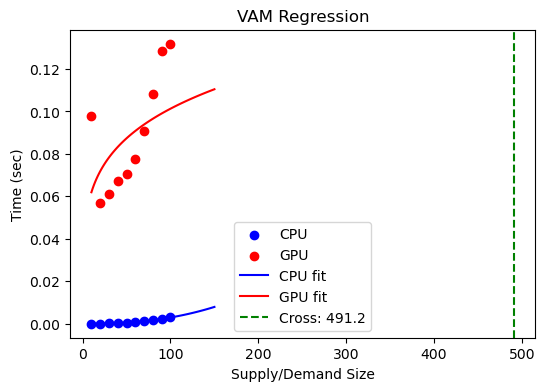

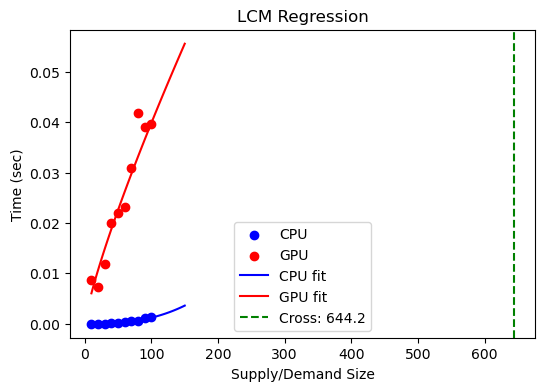

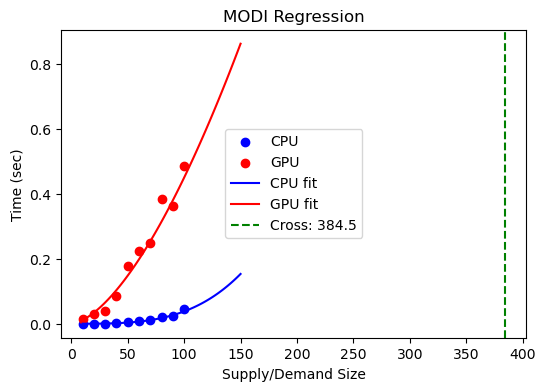

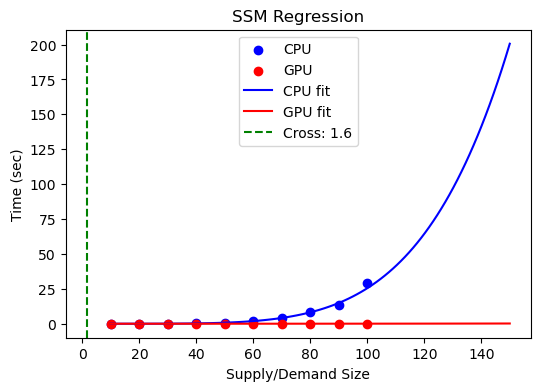

,Algorithm,CPU_a,CPU_b,GPU_a,GPU_b,Crossover
0,VAM,2.434759,-17.037300,0.213614,-3.273381,491.159762
1,LCM,2.698051,-19.146010,0.819650,-6.996600,644.165152
2,MODI,3.439075,-19.108630,1.604202,-8.187477,384.519437
3,SSM,5.090517,-20.205459,3.515104,-19.436998,1.628703


In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
from math import exp
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load CSV data (assumed file name: results.csv)
df = pd.read_csv("results.csv")

# Prepare X variable (supply dimension)
X = df["Supply"].values.reshape(-1, 1)
log_X = np.log(X)

def fit_log_model(y):
    y = np.array(y).reshape(-1, 1)
    log_y = np.log(y)
    reg = LinearRegression().fit(log_X, log_y)
    return reg

def find_crossover(cpu_reg, gpu_reg):
    a1 = cpu_reg.coef_[0][0]
    b1 = cpu_reg.intercept_[0]
    a2 = gpu_reg.coef_[0][0]
    b2 = gpu_reg.intercept_[0]
    if a1 == a2:
        return None
    log_dim = (b2 - b1) / (a1 - a2)
    return exp(log_dim)

# List of algorithm pairs
algorithms = [("CPU VAM", "GPU VAM"),
              ("CPU LCM", "GPU LCM"),
              ("CPU MODI", "GPU MODI"),
              ("CPU SSM",  "GPU SSM")]

results = []
for cpu_alg, gpu_alg in algorithms:
    cpu_times = df[cpu_alg].dropna().values
    gpu_times = df[gpu_alg].dropna().values
    if len(cpu_times)==0 or len(gpu_times)==0:
        continue
    cpu_reg = fit_log_model(cpu_times)
    gpu_reg = fit_log_model(gpu_times)
    crossover = find_crossover(cpu_reg, gpu_reg)
    results.append({
        "Algorithm": cpu_alg.split()[1],
        "CPU_a": cpu_reg.coef_[0][0],
        "CPU_b": cpu_reg.intercept_[0],
        "GPU_a": gpu_reg.coef_[0][0],
        "GPU_b": gpu_reg.intercept_[0],
        "Crossover": crossover
    })
    # Display regression plot
    X_plot = np.linspace(X.min(), X.max() * 1.5, 100).reshape(-1, 1)
    pred_cpu = np.exp(cpu_reg.predict(np.log(X_plot)))
    pred_gpu = np.exp(gpu_reg.predict(np.log(X_plot)))
    
    plt.figure(figsize=(6, 4))
    plt.scatter(X, cpu_times, label="CPU", color="blue")
    plt.scatter(X, gpu_times, label="GPU", color="red")
    plt.plot(X_plot, pred_cpu, label="CPU fit", color="blue")
    plt.plot(X_plot, pred_gpu, label="GPU fit", color="red")
    if crossover is not None:
        plt.axvline(x=crossover, linestyle="--", color="green",
                    label=f"Cross: {crossover:.1f}")
    plt.xlabel("Supply/Demand Size")
    plt.ylabel("Time (sec)")
    plt.title(f"{cpu_alg.split()[1]} Regression")
    plt.legend()
    plt.show()

# Optionally, display regression results
res_df = pd.DataFrame(results)
display(res_df)
